<font color='blue'> **25_Laattoe - Spatially - Periodic Boundary Condition (SPB)** </font> 

In [12]:
import pandas as pd ; import numpy as np ;  import matplotlib.pyplot as plt ; from pathlib import Path ; from flopy.plot.styles import styles ; import flopy 
from modflow_devtools.misc import get_env, timed     ; write=get_env("WRITE", True);run=get_env("RUN", True) 
sim_ws    = Path("./25")                             ; sim_ws.mkdir(exist_ok=True)     ; sim_name = "ex-gwf-spbc"
exe_name  = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'  ; workspace = figs_path = sim_ws       

In [13]:
length_units = "meters" ;time_units = "days" ;nper = 1 ;nlay = 190 ;ncol = 100 ;nrow = 1 ;delr = 0.06 ;delc = 1 ;delv = 0.03 ;
top = 0 ; strt = 0 ;icelltype = 0 ;hydraulic_conductivity = 1 ;nouter = 50 ;ninner = 100 ;hclose = 0.000000001 ;rclose = 0.000001 ;perlen = [1.0] ;
nstp = [1] ;tsmult = [1.0] ;tdis_ds = list(zip(perlen, nstp, tsmult)) ; botm = [top - k * delv for k in range(1, nlay + 1)]

In [14]:
ihc ,cl1 ,cl2 ,hwva = 1,delr/2.0 ,delr/2.0 ,delc   ; angldegx=90.0  ;cdist=delr    ; print(ihc ,cl1 ,cl2 ,hwva, angldegx, cdist)
exgdata  = [[(k,0,0) ,(k,0,ncol-1)                 , ihc ,cl1,cl2 ,hwva  ,angldegx,cdist]  for k in range(nlay)] ; aa=pd.DataFrame(exgdata)

1 0.03 0.03 1 90.0 0.06


In [15]:
print('2... ich=1, cl=0.03, cl=0.03 , hwva(5)=1   ANGLDEGX(90), CDIST (0.06)  ')      
aw = aa.rename(columns = lambda x : 'a' + str(x)) ; aw.tail()
b1 = aw['a0']; b1 = b1.tolist() ; b1=pd.DataFrame(b1); b1 = b1.rename(columns = lambda x : 'Left' + str(x)) 
c1 = aw['a1']; c1 = c1.tolist() ; c1=pd.DataFrame(c1); c1 = c1.rename(columns = lambda x : 'Right' + str(x)) 
df = pd.concat([aa[:], b1[:], c1[:]], axis=1); df.to_csv(sim_ws/"01_exgdata.csv")  ; df.head(3)

2... ich=1, cl=0.03, cl=0.03 , hwva(5)=1   ANGLDEGX(90), CDIST (0.06)  


,0,1,2,3,4,5,6,7,Left0,Left1,Left2,Right0,Right1,Right2
0,"(0, 0, 0)","(0, 0, 99)",1,0.03,0.03,1,90.0,0.06,0,0,0,0,0,99
1,"(1, 0, 0)","(1, 0, 99)",1,0.03,0.03,1,90.0,0.06,1,0,0,1,0,99
2,"(2, 0, 0)","(2, 0, 99)",1,0.03,0.03,1,90.0,0.06,2,0,0,2,0,99


In [16]:
print('Left  column =  ', df['Left2'].max()+1, 'all Layers')  ; print('Right column =', df['Right2'].max()+1, 'all Layers')

Left  column =   1 all Layers
Right column = 100 all Layers


In [17]:
def build_models():

    ihc ,cl1 ,cl2 ,hwva = 1,delr/2.0 ,delr/2.0 ,delc   ; angldegx=90.0  ;cdist=delr
    exgdata          = [[(k,0,0) ,(k,0,ncol-1) ,ihc ,cl1 ,cl2 ,hwva ,angldegx ,cdist]for k in range(nlay)]
 
    sim = flopy.mf6.MFSimulation (sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis    (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms     (sim,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose}strict")
    gwf=flopy.mf6.ModflowGwf (sim,modelname=sim_name,save_flows=True)
    flopy.mf6.ModflowGwfdis  (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
    exg=flopy.mf6.ModflowGwfgwf (sim,exgtype = "GWF6-GWF6"          ,nexg=len(exgdata),
                                 auxiliary   = ["ANGLDEGX","CDIST"] ,exgmnamea = sim_name  ,exgmnameb = sim_name  ,exchangedata = exgdata)
    flopy.mf6.ModflowGwfnpf  (gwf,icelltype  = icelltype,k=hydraulic_conductivity,save_specific_discharge=True)
    flopy.mf6.ModflowGwfic   (gwf,strt = strt)
    
    hm=1.0 ; lmbda=ncol*delr ; wv=2*np.pi/lmbda ; x=gwf.modelgrid.xcellcenters  ; chd_head=hm*np.sin(wv * x)  ; chd_spd=[]
    for j in range(ncol): chd_spd.append([0,0,j,chd_head[0,j]])
        
    flopy.mf6.ModflowGwfchd (gwf ,stress_period_data = chd_spd ,pname="CHD")      ; h_f=f"{sim_name}.hds" ; b_f=f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc  (gwf ,head_filerecord = h_f ,budget_filerecord = b_f  ,saverecord=[("HEAD","ALL"),("BUDGET","ALL")])

    return sim
def write_models(sim, silent=True): sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=False):  success, buff = sim.run_simulation(silent=silent, report=True); assert success, buff
def scenario(silent=True):
    sim = build_models()
    if write:   write_models(sim, silent=silent)
    if run:     run_models(sim, silent=silent)
scenario()

run_models took 304.40 ms


In [18]:
sim = build_models() ; gwf = sim.get_model(sim_name)                                           ; head = gwf.output.head().get_data()
qx, qy, qz   = flopy.utils.postprocessing.get_specific_discharge(gwf.output.budget().get_data(text="DATA-SPDIS", totim=1.0)[0], gwf)
ss =np.max(head) - np.min(head)                      ; levels=np.arange(np.min(head[0]), np.max(head[0]), ss/15) ; print(head.shape)

(190, 1, 100)


<Axes: >

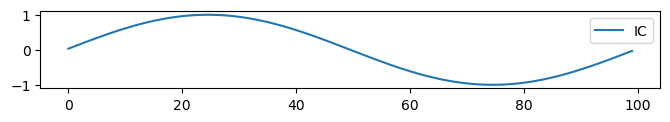

In [19]:
hm=1.0 ; lmbda= ncol * delr ; wv = 2*np.pi/lmbda    ;x=gwf.modelgrid.xcellcenters   ; chd_head = hm*np.sin(wv * x)  ; chd_spd=[]
for j in range(ncol): chd_spd.append([0,0,j,chd_head[0,j]])                         ; ab = pd.DataFrame(chd_spd) ;ab.to_csv(sim_ws/"02_chd_spd.csv")
ab.columns = ['Z','i', 'j', 'IC']; ab.head() ;jJ = ab['j']/ab['j'].max()*6          ; hH = ab['IC']+1 
ab.plot(use_index=True,y='IC',rot=0,figsize=(8,1)) 

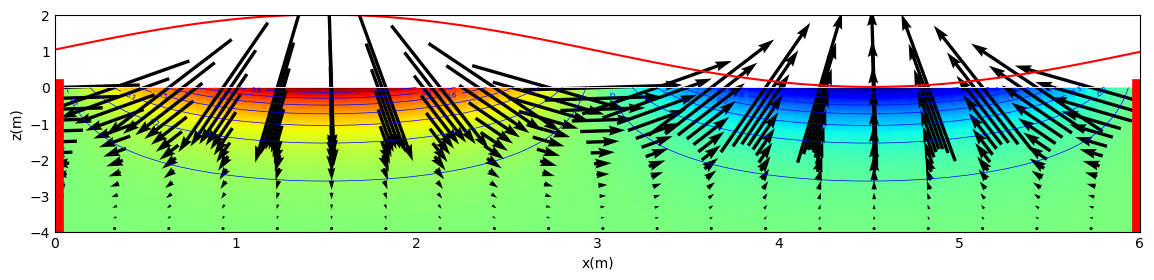

In [24]:
fig = plt.figure(figsize=(14,3))                                        ; ax = fig.add_subplot(111)
pxs = flopy.plot.PlotCrossSection(model = gwf, ax=ax, line={"row": 0}) ; pxs.plot_array(head, cmap="jet") ; pxs.plot_bc("CHD", color="green")  
cs = pxs.contour_array (head, levels=levels, colors="blue", linewidths=0.5, linestyles="-")               ; plt.clabel(cs, fmt="%3.1f", fontsize=5)
pxs.plot_vector  (qx, qy, qz, normalize=False, kstep=10, hstep=5) ; ax.set_xlabel("x(m)")                 ; ax.set_ylabel("z(m)") 
ax.set_ylim(-4, 2) ; styles.remove_edge_ticks(ax)  ; ax.plot(jJ,hH ,"red") ; ax.set_aspect(0.2)           ; pxs.plot_bc("CHD",color="yellow",linewidth=20 )
ax.plot([0,0],[0, -4],color='red',linewidth=12)  ; ax.plot([6,6],[0, -4],color='red', linewidth=12)       ; plt.show() 

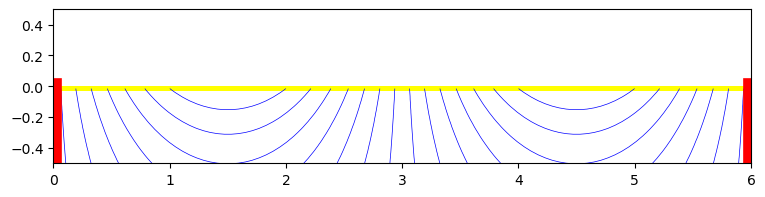

In [21]:
fig = plt.figure(figsize=(9,2))                                                             ; ax = fig.add_subplot(111)
pxs = flopy.plot.PlotCrossSection(model = gwf, ax=ax, line={"row": 0})                         ; ax.set_ylim(-0.5, 0.5) 
pxs.plot_bc("CHD", color="yellow",linewidth=20 )    ; cs = pxs.contour_array (head, levels=levels, colors="blue", linewidths=0.5, linestyles="-") 
ax.plot([0,0],[0, -0.50],color='red',linewidth=12)  ; ax.plot([6,6],[0, -0.50],color='red', linewidth=12)  ; plt.show()

      xX        zZ
95  5.73  0.132632
96  5.79  0.311982
97  5.85  0.506004
98  5.91  0.707998
99  5.97  0.910976


<Axes: xlabel='xX'>

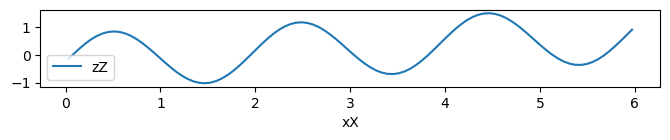

In [22]:
Lx = 6 ;aa = 1  ;alpha = np.arctan2(1, Lx) ;period=2.0 ; bb = 2*np.pi/period  
def toth(z0, aa, bb, alpha, xX):   
    return z0 + xX * np.tan(alpha) + aa * np.sin(bb * xX / np.cos(alpha)) / np.cos(alpha) - 0.25
xX = np.arange(delr / 2, Lx + delr / 2, delr)    ; zZ = toth(top, aa, bb, alpha, xX)      ; chdspd = [[0, 0, j, zZ[j]] for j in range(ncol)]     
ab1=pd.DataFrame(xX); ab2=pd.DataFrame(zZ)       ; df = pd.concat([ab1[:], ab2[:]], axis=1); df.columns= ('xX','zZ') ; print(df.tail())
df.plot(x='xX',y='zZ',rot=0,figsize=(8,1)) 